In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit


In [ ]:
def define_pars(input_size, hidden_size, seed_, bias, vol=0.1, normalize=False):
    key = jax.random.PRNGKey(seed_)
    
    k1, k2, k3, k4, k5, k6, k7, k8 = jax.random.split(key, 8)

    if normalize:
        scale_f = vol * (1 / jnp.sqrt(hidden_size))
    else:
        scale_f = vol

    b_scale = bias #0.3
    # W_i: (input_size + hidden_size, hidden_size)
    W_i = jax.random.normal(k1, (input_size + hidden_size, hidden_size)) * scale_f
    # b_i: (hidden_size,)
    b_i = jax.random.normal(k5, (hidden_size,)) * b_scale
    #b_i = b_scale * jnp.ones((hidden_size,))
    
    # W_f: (input_size + hidden_size, hidden_size)
    W_f = jax.random.normal(k2, (input_size + hidden_size, hidden_size)) * scale_f
    # b_f: (hidden_size,)
    b_f = jax.random.normal(k6, (hidden_size,)) * b_scale
    #b_f = b_scale * jnp.ones((hidden_size,))
    
    # W_c: (input_size + hidden_size, hidden_size)
    W_c = jax.random.normal(k3, (input_size + hidden_size, hidden_size)) * scale_f
    # b_c: (hidden_size,)
    b_c = jax.random.normal(k7, (hidden_size,)) * b_scale
    #b_c = b_scale * jnp.ones((hidden_size,))
    
    # W_o: (input_size + hidden_size, hidden_size)
    W_o = jax.random.normal(k4, (input_size + hidden_size, hidden_size)) * scale_f
    # b_o: (hidden_size,)
    b_o = jax.random.normal(k8, (hidden_size,)) * b_scale
    #b_o = b_scale * jnp.ones((hidden_size,))

    return (W_i, b_i, W_f, b_f, W_c, b_c, W_o, b_o)

# Adjusted LSTMCell_test function
def LSTMCell_test(inputs, hidden_size, seed_, bias, vol=0.1, normalize=False):
    from jax.nn import sigmoid, tanh
    from jax.lax import scan

    # take always last dimension 
    num_ts, input_size = inputs.shape[-2], inputs.shape[-1]
    input_list = [input_size] 
    input_list += hidden_size[:-1]
    
    pars = {lr: define_pars(input_list[lr], hsz, seed_, bias, vol=vol, normalize=normalize) for lr, hsz in enumerate(hidden_size)}
    
    def f_scan(carry, x):
        h, c, W_i, b_i, W_f, b_f, W_c, b_c, W_o, b_o = carry
        
        # Concatenate current time step input with hidden state
        z = jnp.concatenate([x, h], axis=-1)

        i = sigmoid(jnp.dot(z, W_i) + b_i)
        f = sigmoid(jnp.dot(z, W_f) + b_f)
        o = sigmoid(jnp.dot(z, W_o) + b_o)
        c_hat = tanh(jnp.dot(z, W_c) + b_c)

        c = f * c + i * c_hat
        h = o * tanh(c)
        
        return (h, c, W_i, b_i, W_f, b_f, W_c, b_c, W_o, b_o), h
        
    
    key = jax.random.PRNGKey(0)  

    # Initial hidden and cell states
    for lr, hsz in enumerate(hidden_size):
        key, subkey = jax.random.split(key)  
        h0 = jax.random.normal(subkey, (hsz,))  
        
        c0 = jnp.zeros(hsz) 
        initial_state = (h0, c0) + pars[lr]
        final_state, outputs = scan(f_scan, initial_state, inputs)
        inputs = outputs  

    return final_state, outputs

In [ ]:
import numpy as np
from scipy.optimize import curve_fit
import jax
import jax.numpy as jnp

def exp_decay(t, A, tau, C):
    return A * np.exp(-t / tau) + C

# Parameters
key = jax.random.PRNGKey(8)
input_size = 3
hidden_size = [1000]
g_factors = np.linspace(0.5, 1.5, 50)
g_critico = 2 / jnp.sqrt(hidden_size[0])
num_steps = 1000
num_seeds = 50
bias_values = [0.02,0.03,0.04, 0.05, 0.06] 
tau_results = np.zeros((len(bias_values), len(g_factors))) 

def calculate_norm(h_t):
    return jnp.sqrt(jnp.mean(h_t ** 2))

# Iterazione su bias
for b_idx, b in enumerate(bias_values):
    # Iterazione su g_factors
    for g_idx, g_factor in enumerate(g_factors):
        g = g_factor * g_critico
        all_norms_over_time = []
        tau = []
        # Iterazione su diversi seed
        for seed in range(num_seeds):
            inputs = jnp.zeros((num_steps, input_size))
            final_state, outputs = LSTMCell_test(inputs, hidden_size, seed, b, vol=g, normalize=False)
            norms_over_time = jnp.array([calculate_norm(h_t) for h_t in outputs])
            fixed_points = np.mean(norms_over_time[-10:])
            norms_centered = np.abs(fixed_points - norms_over_time)
            popt, _ = curve_fit(exp_decay, np.arange(num_steps), norms_centered)
            tau.append(popt[1] if popt[1] < num_steps else num_steps)

        tau_results[b_idx, g_idx] = np.nanmean(tau)  
        print(f"bias: {b:.2f}, g_factor: {g_factor:.2f}, avg_tau: {tau_results[b_idx, g_idx]:.2f}")


bias: 0.02, g_factor: 0.50, avg_tau: 2.93
bias: 0.02, g_factor: 0.52, avg_tau: 2.69
bias: 0.02, g_factor: 0.54, avg_tau: 2.49
bias: 0.02, g_factor: 0.56, avg_tau: 2.34
bias: 0.02, g_factor: 0.58, avg_tau: 2.24
bias: 0.02, g_factor: 0.60, avg_tau: 2.20
bias: 0.02, g_factor: 0.62, avg_tau: 2.17
bias: 0.02, g_factor: 0.64, avg_tau: 2.26
bias: 0.02, g_factor: 0.66, avg_tau: 2.43
bias: 0.02, g_factor: 0.68, avg_tau: 2.67
bias: 0.02, g_factor: 0.70, avg_tau: 2.98
bias: 0.02, g_factor: 0.72, avg_tau: 3.55
bias: 0.02, g_factor: 0.74, avg_tau: 4.12
bias: 0.02, g_factor: 0.77, avg_tau: 5.13


/var/folders/87/_88j16k118z6hwpfvycnp0rc0000gn/T/ipykernel_6784/525904030.py:37: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(exp_decay, np.arange(num_steps), norms_centered)
/var/folders/87/_88j16k118z6hwpfvycnp0rc0000gn/T/ipykernel_6784/525904030.py:7: RuntimeWarning: overflow encountered in exp
  return A * np.exp(-t / tau) + C


bias: 0.02, g_factor: 0.79, avg_tau: 6.26
bias: 0.02, g_factor: 0.81, avg_tau: 7.62
bias: 0.02, g_factor: 0.83, avg_tau: 9.08
bias: 0.02, g_factor: 0.85, avg_tau: 10.76
bias: 0.02, g_factor: 0.87, avg_tau: 12.91
bias: 0.02, g_factor: 0.89, avg_tau: 15.15
bias: 0.02, g_factor: 0.91, avg_tau: 19.58
bias: 0.02, g_factor: 0.93, avg_tau: 25.53
bias: 0.02, g_factor: 0.95, avg_tau: 37.34
bias: 0.02, g_factor: 0.97, avg_tau: 51.82
bias: 0.02, g_factor: 0.99, avg_tau: 53.48
bias: 0.02, g_factor: 1.01, avg_tau: 75.15
bias: 0.02, g_factor: 1.03, avg_tau: 72.66
bias: 0.02, g_factor: 1.05, avg_tau: 42.90
bias: 0.02, g_factor: 1.07, avg_tau: 37.01
bias: 0.02, g_factor: 1.09, avg_tau: 28.44
bias: 0.02, g_factor: 1.11, avg_tau: 26.37
bias: 0.02, g_factor: 1.13, avg_tau: 23.90
bias: 0.02, g_factor: 1.15, avg_tau: 21.37
bias: 0.02, g_factor: 1.17, avg_tau: 19.89
bias: 0.02, g_factor: 1.19, avg_tau: 18.10
bias: 0.02, g_factor: 1.21, avg_tau: 17.21
bias: 0.02, g_factor: 1.23, avg_tau: 16.65
bias: 0.02, g_

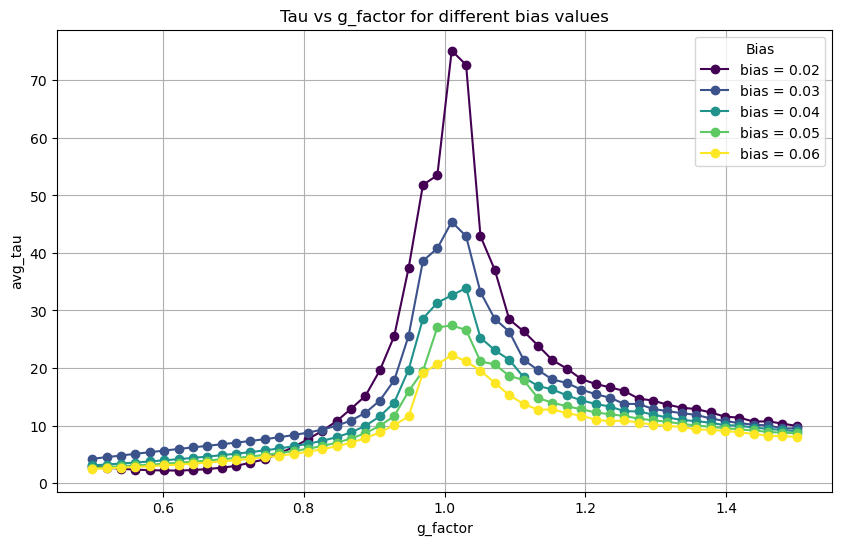

In [ ]:
cmap = plt.get_cmap('viridis')  
colors = [cmap(i) for i in np.linspace(0, 1, len(bias_values))]

plt.figure(figsize=(10, 6))

for b_idx, b in enumerate(bias_values):
    plt.plot(g_factors, tau_results[b_idx, :], label=f'bias = {b}', color=colors[b_idx], marker='o')

plt.title('Tau vs g_factor for different bias values')
plt.xlabel('g_factor')
plt.ylabel('avg_tau')
plt.legend(title='Bias')
plt.grid(True)
plt.show() 